In this notebook we'll make the basic forward pass and training loop for a fully connected network:
- Inference logic, doing matrix multiplication to multiply each weight of each neuron by the associated value of the layer before it, and add bias, then do relu activation
- Softmax function to turn final output into a representation of the probability distribution over predictions.
- Cross Entropy Loss function which will be the objective we're trying to minimize
- Utilizing pytorch's backpropagation to get the gradient, but then updating parameters manually with it and the learning rate
- Iterating over epochs, and inside of epochs iterating over randomized minibatches, so that we're doing *stochastic* gradient descent.
- **(Skip to the end for this) pick a random number out of the training set and show what the prediction is for the image**

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
from urllib.request import urlretrieve

In [2]:
mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

In [3]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

In [4]:
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [5]:
TRAIN_SIZE=x_train.shape[0]
BATCH_SIZE=10000
LEARNING_RATE = 0.1

In [6]:
def init_params(size):
    '''
    Xavier Weight Initialization
    strategy for initializing values of weights meant to prevent gradient vanishing or explosion.
    '''
    bound = math.sqrt(1.0 / size[0])
    return torch.randn(size).uniform_(-bound, bound).requires_grad_()

def softmax(x):
    e=x.exp()
    return e / e.sum(-1,keepdim=True)

def CrossEntropyLoss(p,y):
    losst = -(p[range(p.shape[0]),y].log())
    result = losst.mean()
    return result

class HomebrewModel:
    def __init__(self):
        '''
        784: number of input features (pixels in 28x28 image)
        200: number of feaures in the hidden layer (can be arbitrarily chosen)
        '''
        self.weights1 = init_params((784, 200)) # 
        self.bias1    = init_params((200, ))
        '''
        200: match the output coming from features of hidden layer
        10: 10 possible output classifications (corresponding to the digits 0-9)
        '''
        self.weights2 = init_params((200, 10))
        self.bias2    = init_params((10,))
        
    def predict(self,x):
        # For each feature of the hidden layer, sum the products of each input feature with a corresponding weight and add a bias
        x = (x@self.weights1 + self.bias1)
        
        # This is relu aka rectified linear unit activation
        x = x.max(tensor(0.0))
        
        x = (x@self.weights2 + self.bias2)
        
        return softmax(x)
    
    def parameters(self):
        return [self.weights1, self.bias1, self.weights2, self.bias2]


In [7]:
'''
epoch goes through entire training set
'''
def train_epoch(model):
    rand_indexes=torch.randperm(TRAIN_SIZE)
    '''
    each batch is a random subset of the training set, loop over batches to cover all training data
    '''
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):
        # pull the random batch
        idxs = rand_indexes[i : i + BATCH_SIZE]
        xb = x_train[idxs]
        yb = y_train[idxs]
        train_batch(model, xb, yb)

                
    # at the end of epoch, check model performance against validation data
    with torch.no_grad():
        valid_preds = model.predict(x_valid)
        validation_acc = batch_accuracy(valid_preds, y_valid)
        validation_loss = CrossEntropyLoss(valid_preds, y_valid)
        print(f'valid/acc: {validation_acc}\t valid/loss: {validation_loss}')

def train_batch(model, xb, yb):
    preds = model.predict(xb)
    loss = CrossEntropyLoss(preds, yb)

    # compute gradients: done by pytorch, see next notebook for backpropagation demonstration
    loss.backward()

    with torch.no_grad():
        # update parameters to descend the gradient
        for p in model.parameters():
            p -= LEARNING_RATE * p.grad
            p.grad.zero_()   
    
def batch_accuracy(preds_b, yb):
    correct = (preds_b.argmax(1)) == yb
    return correct.float().mean()

In [8]:
model = HomebrewModel()
for epoch in range(25):
    train_epoch(model)

valid/acc: 0.2662000060081482	 valid/loss: 2.196192979812622
valid/acc: 0.5465999841690063	 valid/loss: 2.0844383239746094
valid/acc: 0.6901000142097473	 valid/loss: 1.9524739980697632
valid/acc: 0.7348999977111816	 valid/loss: 1.7984671592712402
valid/acc: 0.7537000179290771	 valid/loss: 1.6301344633102417
valid/acc: 0.7685999870300293	 valid/loss: 1.4609266519546509
valid/acc: 0.7825000286102295	 valid/loss: 1.304023265838623
valid/acc: 0.7993999719619751	 valid/loss: 1.1670347452163696
valid/acc: 0.8137000203132629	 valid/loss: 1.0517596006393433
valid/acc: 0.8274999856948853	 valid/loss: 0.9565532207489014
valid/acc: 0.8364999890327454	 valid/loss: 0.8780364990234375
valid/acc: 0.8454999923706055	 valid/loss: 0.8130989670753479
valid/acc: 0.8508999943733215	 valid/loss: 0.7588340044021606
valid/acc: 0.8554999828338623	 valid/loss: 0.7132889032363892
valid/acc: 0.8611000180244446	 valid/loss: 0.6744224429130554
valid/acc: 0.8644999861717224	 valid/loss: 0.6411890387535095
valid/acc:

# Pick a random number and try
After running above cells, run cell below as many times as you please to pick a random number from the training set, see it, and see the prediction made for it

Prediction: 7
Confidence: 25.4%
Label: 2


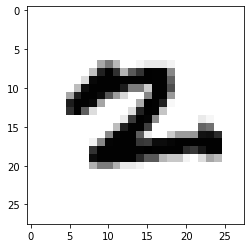

In [23]:
i=torch.randint(0,TRAIN_SIZE-1, (1,)).item()
preds = model.predict(x_train[i])
prediction = preds.argmax()
confidence = preds[prediction]
print(f'Prediction: {prediction}\nConfidence: {confidence:.1%}\nLabel: {y_train[i]}')
plt.imshow(x_train[i].view(28, 28) * -1.0)